Train Model

In [1]:
import numpy as np
import gzip
import keras
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#If we want to avoid zero-padding, then the input seq len will be determined
# by parameters of the convolutions
class AbstractProfileModel(object):

    def get_output_profile_len(self):
        raise NotImplementedError()

    def get_model(self):
        raise NotImplementedError()

def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer

#model architecture is based on 
#https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/models.py#L534
#The non-cli parameters are specified in:
# https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/src/chipnexus/train/seqmodel/joint-model-valid.gin
#The cli parameters are in line 165 of:
# https://docs.google.com/spreadsheets/d/1n3l2HXKSNpmNUOifD41uRzDEAgmOqXMQDxquRaz6WLg/edit#gid=0
# which seems to match https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/src/chipnexus/train/seqmodel/ChIP-seq-default.gin
class RcBPnetArch(AbstractProfileModel):   

    def __init__(self, input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr):
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr

    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len

    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len

    def get_keras_model(self):

        out_pred_len = self.get_output_profile_len()

        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = RevCompConv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        bias_counts_input = kl.Input(shape=(1,), name="control_logcount")
        bias_profile_input = kl.Input(shape=(out_pred_len, 2),
                                      name="control_profile")
        prev_layers = [first_conv]
        for i in range(1, self.n_dil_layers + 1):
          dilation_rate = 2**i
          if i == 1:
              prev_sum = first_conv
          else:
              print(prev_layers)
              prev_sum = kl.merge.Average()(prev_layers)
          conv_output = RevCompConv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_sum)          
          width_to_trim = dilation_rate*(self.dil_kernel_size-1)
          curr_layer_size = (curr_layer_size - width_to_trim)
          prev_layers = [trim_flanks_of_conv_layer(
              conv_layer=x, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=2*self.filters)
              for x in prev_layers]
          prev_layers.append(conv_output)

        combined_conv = kl.merge.Average()(prev_layers)

        #Counts prediction
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        count_out = kl.Reshape((-1,), name="task0_logcount")(
            RevCompConv1D(filters=1, kernel_size=1)(
              kl.Reshape((1,-1))(kl.concatenate([
                  #concatenation of the bias layer both before and after
                  # is needed for rc symmetry
                  kl.Lambda(lambda x: x[:, ::-1])(bias_counts_input),
                  gap_combined_conv,
                  bias_counts_input], axis=-1))))

        profile_out_prebias = RevCompConv1D(
                               filters=1,
                               kernel_size=self.outconv_kernel_size,
                               padding='valid')(combined_conv)
        profile_out = RevCompConv1D(
            filters=1, kernel_size=1, name="task0_profile")(
                    kl.concatenate([
                        #concatenation of the bias layer both before and after
                        # is needed for rc symmetry
                        kl.Lambda(lambda x: x[:, :, ::-1])(bias_profile_input),
                        profile_out_prebias,
                        bias_profile_input], axis=-1))

        model = keras.models.Model(
          inputs=[inp, bias_counts_input, bias_profile_input],
          outputs=[count_out, profile_out])
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=['mse', MultichannelMultinomialNLL(2)],
                      loss_weights=[self.c_task_weight, 1])
        return model

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
seq_len = 546
modelwrapper = RcBPnetArch(
    input_seq_len=seq_len, c_task_weight=250,
    filters=25,
    n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=50,
    lr=0.001)
out_pred_len = modelwrapper.get_output_profile_len()
print(out_pred_len, seq_len-out_pred_len)

225 321


In [3]:
pos_neg_smooth_log_counts =\
  coordstovals.bigwig.PosAndNegSmoothWindowCollapsedLogCounts(
        pos_strand_bigwig_path="/users/amr1/pho4/data/ctl_chipexo/chipexo.pos_strand.bw",
        neg_strand_bigwig_path="/users/amr1/pho4/data/ctl_chipexo/chipexo.neg_strand.bw",
        counts_mode_name="control_logcount",
        profile_mode_name="control_profile",
        center_size_to_use=out_pred_len,
        smoothing_windows=[1,50])
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="/users/amr1/pho4/data/genome/saccer/sacCer3.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      pos_neg_smooth_log_counts])

targets_coordstovals = coordstovals.bigwig.PosAndNegSeparateLogCounts(
    pos_strand_bigwig_path="/users/amr1/pho4/data/abf1_chipexo/basename_prefix.pooled.positive.bigwig",
    neg_strand_bigwig_path="/users/amr1/pho4/data/abf1_chipexo/basename_prefix.pooled.negative.bigwig",
    counts_mode_name="task0_logcount",
    profile_mode_name="task0_profile",
    center_size_to_use=out_pred_len)

keras_train_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="/users/amr1/pho4/data/abf1_chipexo/train_1000_around_summits.bed.gz",
      coord_batch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="/users/amr1/pho4/data/genome/saccer/sacCer3.chrom.sizes")),
      batch_size=32,
      shuffle_before_epoch=True, 
      seed=1234),
    inputs_coordstovals=inputs_coordstovals,
    targets_coordstovals=targets_coordstovals)

keras_valid_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/abf1_chipexo/valid_1000_around_summits.bed.gz",
            batch_size=32,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

thebatch = keras_train_batch_generator[0]
for tupleidx,tupleentry in enumerate(thebatch):
  print("Tuple entry",tupleidx)
  for key in tupleentry:
    print(key, tupleentry[key].shape)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Tuple entry 0
sequence (64, 546, 4)
control_logcount (64,)
control_profile (64, 225, 2)
Tuple entry 1
task0_logcount (64, 2)
task0_profile (64, 225, 2)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                          patience=25, restore_best_weights=True)
loss_history = model.fit_generator(keras_train_batch_generator,
                  epochs=500,
                  validation_data=keras_valid_batch_generator,
                  callbacks=[early_stopping_callback])
model.set_weights(early_stopping_callback.best_weights)




[<tf.Tensor 'lambda_1/strided_slice:0' shape=(?, 522, 50) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_2/Relu:0' shape=(?, 522, 50) dtype=float32>]
[<tf.Tensor 'lambda_2/strided_slice:0' shape=(?, 514, 50) dtype=float32>, <tf.Tensor 'lambda_3/strided_slice:0' shape=(?, 514, 50) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_3/Relu:0' shape=(?, 514, 50) dtype=float32>]
[<tf.Tensor 'lambda_4/strided_slice:0' shape=(?, 498, 50) dtype=float32>, <tf.Tensor 'lambda_5/strided_slice:0' shape=(?, 498, 50) dtype=float32>, <tf.Tensor 'lambda_6/strided_slice:0' shape=(?, 498, 50) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_4/Relu:0' shape=(?, 498, 50) dtype=float32>]
[<tf.Tensor 'lambda_7/strided_slice:0' shape=(?, 466, 50) dtype=float32>, <tf.Tensor 'lambda_8/strided_slice:0' shape=(?, 466, 50) dtype=float32>, <tf.Tensor 'lambda_9/strided_slice:0' shape=(?, 466, 50) dtype=float32>, <tf.Tensor 'lambda_10/strided_slice:0' shape=(?, 466, 50) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_5/Relu:0' shape

In [5]:
model.save('/users/amr1/pho4/data/models/abf1_chipexo.h5')

In [6]:
from keras.models import load_model
from keras.utils import CustomObjectScope

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model('/users/amr1/pho4/data/models/abf1_chipexo.h5')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 546, 4)       0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 526, 50)      2125        sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 522, 50)      0           rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
rev_comp_conv1d_2 (RevCompConv1 (None, 522, 50)      3775        rev_comp_conv1d_1[0][0]          
__________________________________________________________________________________________________
average_1 

evaluate

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


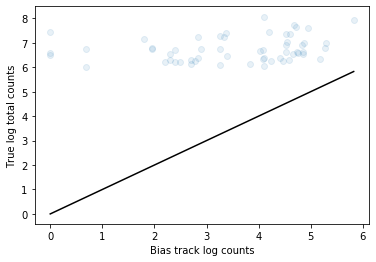

SpearmanrResult(correlation=0.2997665899284609, pvalue=0.023486837220531794)


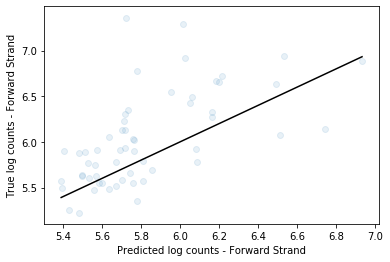

SpearmanrResult(correlation=0.6666018477006052, pvalue=1.5090780945150096e-08)


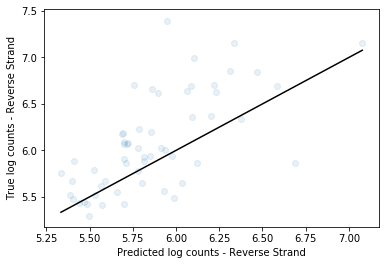

SpearmanrResult(correlation=0.6852698107633992, pvalue=4.0964626540517856e-09)


In [7]:
o_test_preds_logcount = []
o_test_biastrack_logcount = []
o_test_biastrack_profile = []
o_test_seqs = []
o_test_preds_profile = []
o_test_labels_logcount = []
o_test_labels_profile = []

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/abf1_chipexo/test_1000_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

orig_seqs = []

for batch_idx in range(len(keras_test_batch_generator)):
    batch_inputs, batch_labels = keras_test_batch_generator[batch_idx]
    o_test_seqs.append(batch_inputs['sequence']) 
    o_test_biastrack_logcount.append(batch_inputs['control_logcount'])
    o_test_biastrack_profile.append(batch_inputs['control_profile'])    
    test_preds = model.predict(batch_inputs)
    o_test_preds_logcount.append(test_preds[0])
    o_test_preds_profile.append(test_preds[1])
    o_test_labels_logcount.append(batch_labels['task0_logcount'])
    o_test_labels_profile.append(batch_labels['task0_profile'])
o_test_biastrack_logcount = np.concatenate(o_test_biastrack_logcount, axis=0)
o_test_biastrack_profile = np.concatenate(o_test_biastrack_profile,axis=0)
o_test_seqs = np.concatenate(o_test_seqs,axis=0)
o_test_preds_logcount = np.concatenate(o_test_preds_logcount, axis=0)
o_test_preds_profile = np.concatenate(o_test_preds_profile, axis=0)
o_test_labels_logcount = np.concatenate(o_test_labels_logcount, axis=0)
o_test_labels_profile = np.concatenate(o_test_labels_profile, axis=0)

from matplotlib import pyplot as plt
from scipy.stats import spearmanr

o_test_labels_logtotalcount = np.log(np.sum(np.exp(o_test_labels_logcount) - 1,axis=-1) + 1)

plt.scatter(o_test_biastrack_logcount, o_test_labels_logtotalcount, alpha=0.1)
plt.xlabel("Bias track log counts")
plt.ylabel("True log total counts")
plt.plot([np.min(o_test_biastrack_logcount), np.max(o_test_biastrack_logcount)],
         [np.min(o_test_biastrack_logcount), np.max(o_test_biastrack_logcount)],
         color="black")
plt.show()
print(spearmanr(o_test_biastrack_logcount, o_test_labels_logtotalcount))


#do a scatterplot of total count predictions
plt.scatter(o_test_preds_logcount[:,0], o_test_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(o_test_preds_logcount[:,0]), np.max(o_test_preds_logcount[:,0])],
         [np.min(o_test_preds_logcount[:,0]), np.max(o_test_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(o_test_preds_logcount[:,0], o_test_labels_logcount[:,0]))

plt.scatter(o_test_preds_logcount[:,1], o_test_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(o_test_preds_logcount[:,1]), np.max(o_test_preds_logcount[:,1])],
         [np.min(o_test_preds_logcount[:,1]), np.max(o_test_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(o_test_preds_logcount[:,1], o_test_labels_logcount[:,1]))

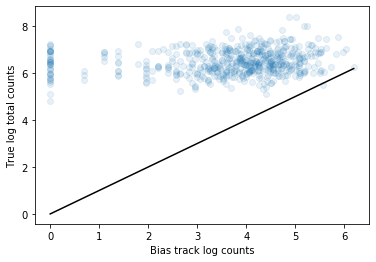

SpearmanrResult(correlation=0.1634524955143274, pvalue=0.00010211515257773442)


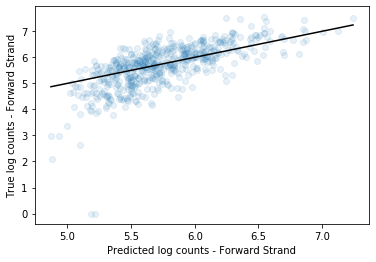

SpearmanrResult(correlation=0.7275455593384785, pvalue=2.268349513607332e-93)


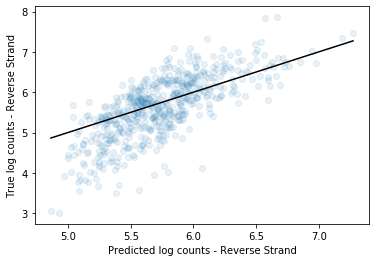

SpearmanrResult(correlation=0.742370662793405, pvalue=4.009450630415597e-99)


In [8]:
%matplotlib inline

o_train_preds_logcount = []
o_train_biastrack_logcount = []
o_train_biastrack_profile = []
o_train_seqs = []
o_train_preds_profile = []
o_train_labels_logcount = []
o_train_labels_profile = []

orig_seqs = []

for batch_idx in range(len(keras_train_batch_generator)):
    batch_inputs, batch_labels = keras_train_batch_generator[batch_idx]
    o_train_seqs.append(batch_inputs['sequence']) 
    o_train_biastrack_logcount.append(batch_inputs['control_logcount'])
    o_train_biastrack_profile.append(batch_inputs['control_profile'])    
    train_preds = model.predict(batch_inputs)
    o_train_preds_logcount.append(train_preds[0])
    o_train_preds_profile.append(train_preds[1])
    o_train_labels_logcount.append(batch_labels['task0_logcount'])
    o_train_labels_profile.append(batch_labels['task0_profile'])
o_train_biastrack_logcount = np.concatenate(o_train_biastrack_logcount, axis=0)
o_train_biastrack_profile = np.concatenate(o_train_biastrack_profile,axis=0)
o_train_seqs = np.concatenate(o_train_seqs,axis=0)
o_train_preds_logcount = np.concatenate(o_train_preds_logcount, axis=0)
o_train_preds_profile = np.concatenate(o_train_preds_profile, axis=0)
o_train_labels_logcount = np.concatenate(o_train_labels_logcount, axis=0)
o_train_labels_profile = np.concatenate(o_train_labels_profile, axis=0)

from matplotlib import pyplot as plt
from scipy.stats import spearmanr

o_train_labels_logtotalcount = np.log(np.sum(np.exp(o_train_labels_logcount) - 1,axis=-1) + 1)

plt.scatter(o_train_biastrack_logcount, o_train_labels_logtotalcount, alpha=0.1)
plt.xlabel("Bias track log counts")
plt.ylabel("True log total counts")
plt.plot([np.min(o_train_biastrack_logcount), np.max(o_train_biastrack_logcount)],
         [np.min(o_train_biastrack_logcount), np.max(o_train_biastrack_logcount)],
         color="black")
plt.show()
print(spearmanr(o_train_biastrack_logcount, o_train_labels_logtotalcount))


#do a scatterplot of total count predictions
plt.scatter(o_train_preds_logcount[:,0], o_train_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(o_train_preds_logcount[:,0]), np.max(o_train_preds_logcount[:,0])],
         [np.min(o_train_preds_logcount[:,0]), np.max(o_train_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(o_train_preds_logcount[:,0], o_train_labels_logcount[:,0]))

plt.scatter(o_train_preds_logcount[:,1], o_train_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(o_train_preds_logcount[:,1]), np.max(o_train_preds_logcount[:,1])],
         [np.min(o_train_preds_logcount[:,1]), np.max(o_train_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(o_train_preds_logcount[:,1], o_train_labels_logcount[:,1]))

Interpretation

In [9]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [10]:
#The shap scores
post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
    [o_test_seqs, np.zeros((len(o_test_seqs), 1))],
    progress_message=10)
post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
    [o_test_seqs, np.zeros((len(o_test_seqs), out_pred_len, 2))],
    progress_message=10)

post_counts_actualimps = post_counts_hypimps*o_test_seqs
post_profile_actualimps = post_profile_hypimps*o_test_seqs

Done 0 examples of 57
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 10 examples of 57
Done 20 examples of 57
Done 30 examples of 57
Done 40 examples of 57
Done 50 examples of 57
Done 0 examples of 57
Done 10 examples of 57
Done 20 examples of 57
Done 30 examples of 57
Done 40 examples of 57
Done 50 examples of 57


idx 13
Counts [1575. 1631.]
Predcounts [305.08566 382.518  ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


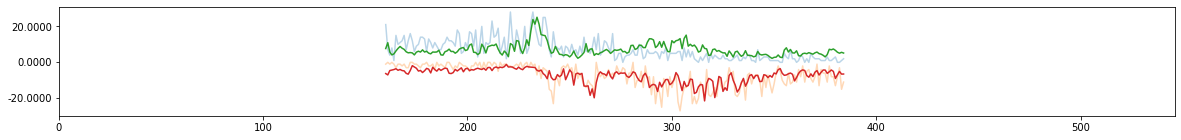

counts imp


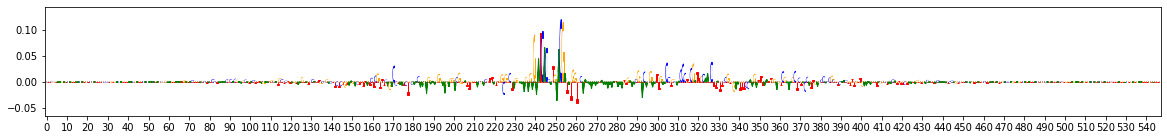

profile imp


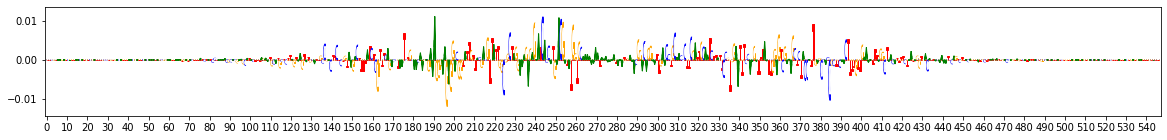

idx 50
Counts [1460. 1275.]
Predcounts [409.2245 564.9241]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


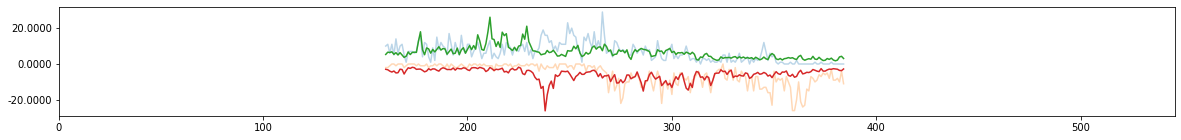

counts imp


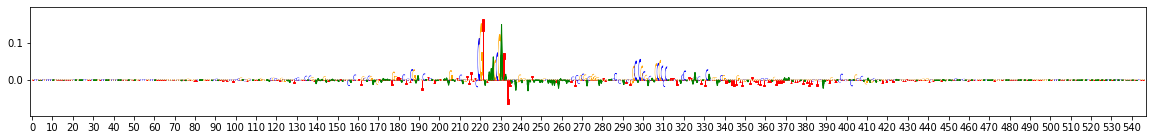

profile imp


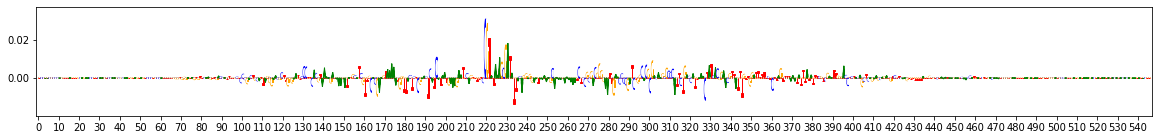

idx 25
Counts [ 976. 1284.]
Predcounts [1024.6293 1184.0463]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


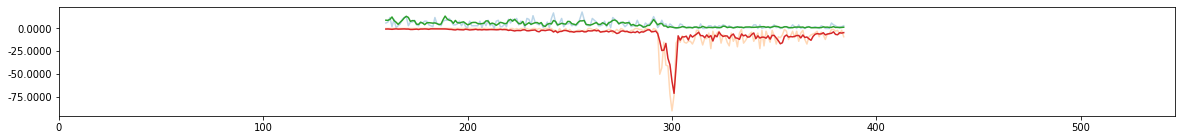

counts imp


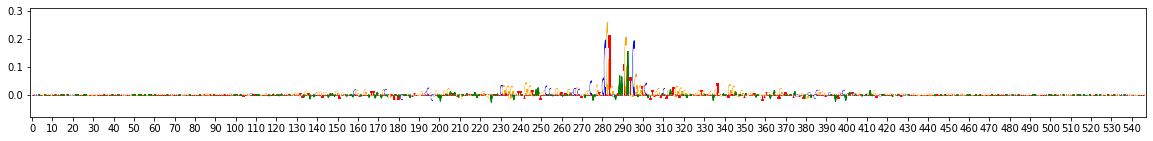

profile imp


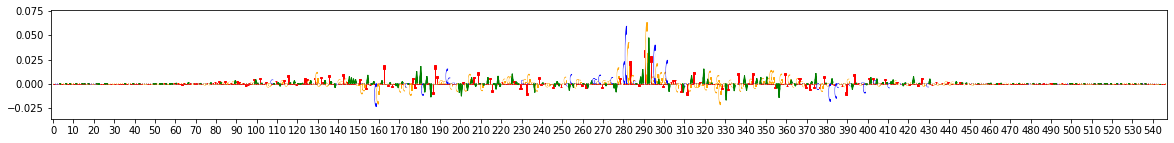

idx 0
Counts [1012. 1088.]
Predcounts [412.82416 446.46277]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


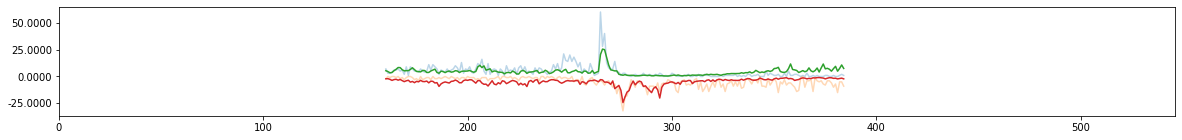

counts imp


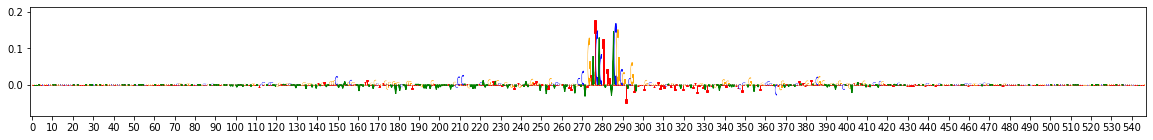

profile imp


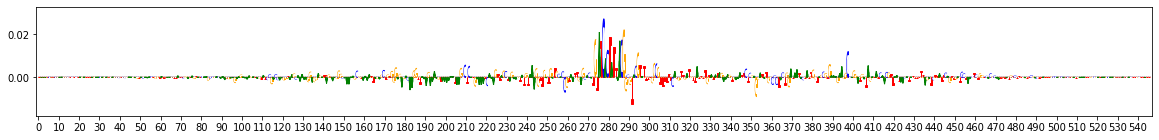

idx 56
Counts [1038.  932.]
Predcounts [687.0606  644.82654]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


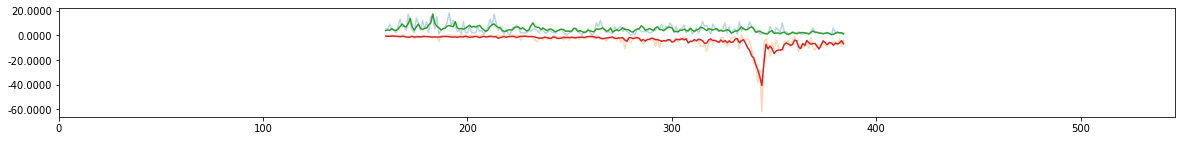

counts imp


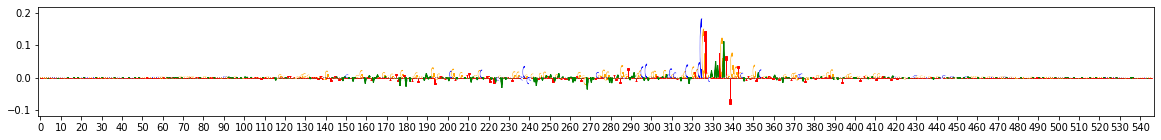

profile imp


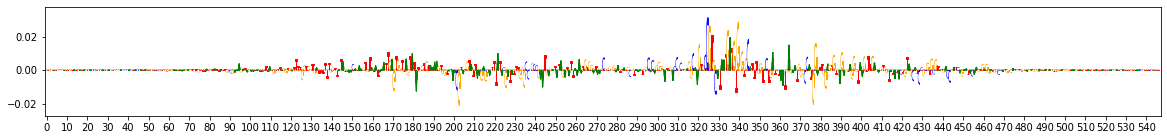

idx 44
Counts [787. 951.]
Predcounts [483.98584 550.1171 ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


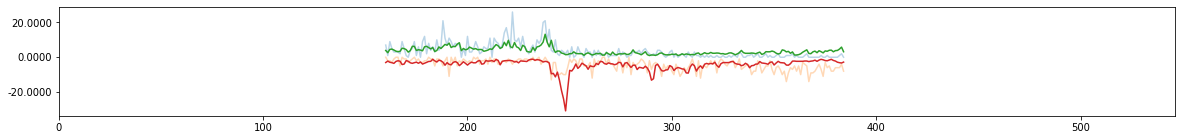

counts imp


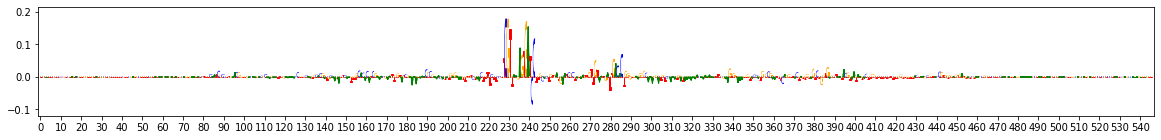

profile imp


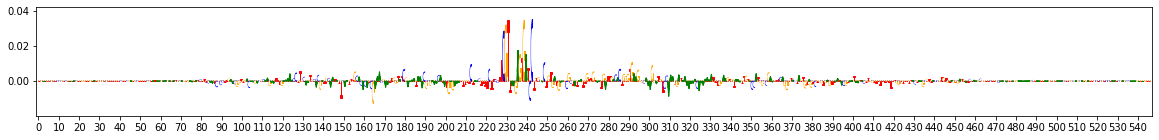

idx 34
Counts [879. 812.]
Predcounts [322.82935 316.03412]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


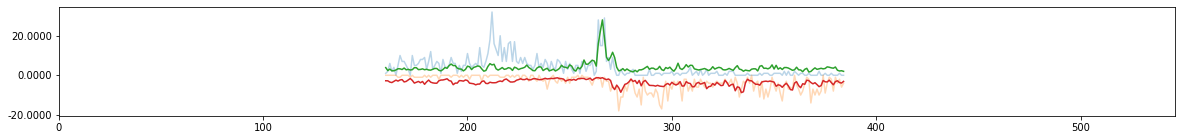

counts imp


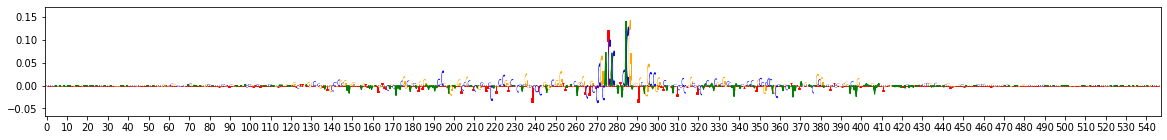

profile imp


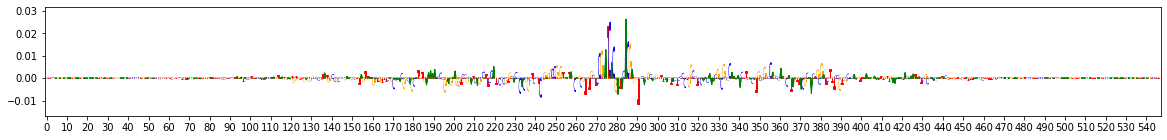

idx 4
Counts [831. 802.]
Predcounts [499.4573 437.9175]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


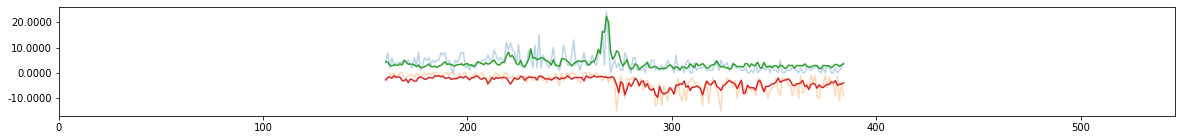

counts imp


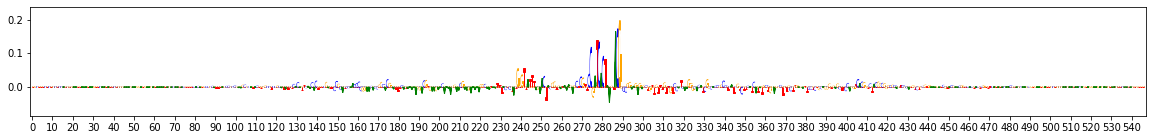

profile imp


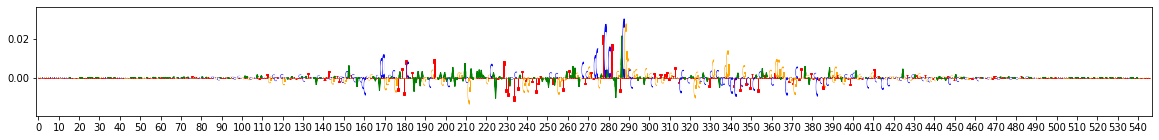

idx 2
Counts [774. 817.]
Predcounts [492.12784 501.0714 ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


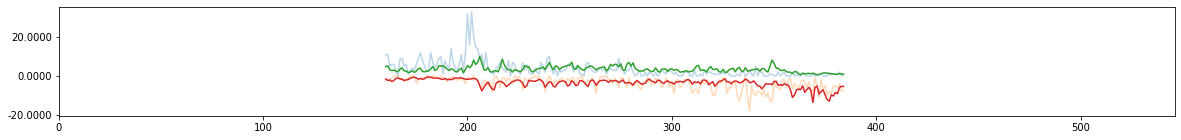

counts imp


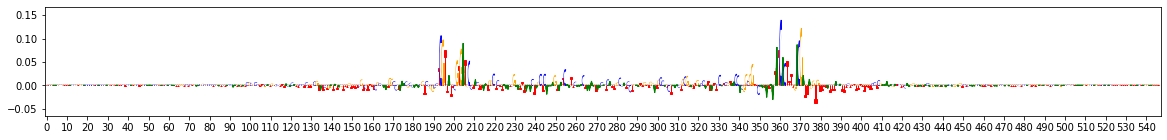

profile imp


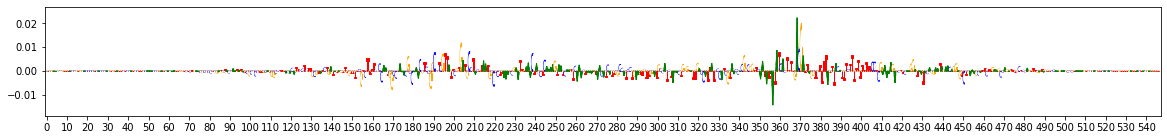

idx 26
Counts [761. 803.]
Predcounts [660.7153 723.7038]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


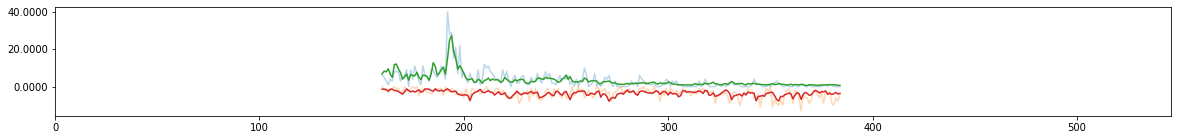

counts imp


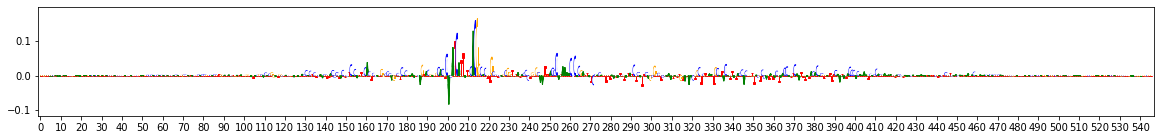

profile imp


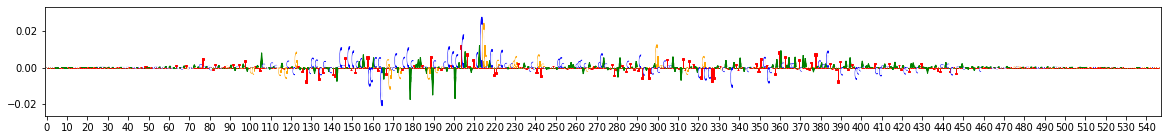

In [11]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

sorted_test_indices = [x[0] for x in 
                       sorted(enumerate(o_test_labels_logtotalcount),
                              key=lambda x: -x[1])]

def smooth(vals):
    return np.convolve(vals, np.ones(1,)/1, mode='same')

for idx in sorted_test_indices[:10]: 
    true_profile = o_test_labels_profile[idx] 
    print("idx",idx)
    print("Counts",np.sum(true_profile,axis=0))
    print("Predcounts",np.exp(o_test_preds_logcount[idx])-1)
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(o_test_labels_profile[idx].shape)
        print("Pred profile shape", o_test_preds_profile[idx].shape)
        pred_profile = (np.sum(o_test_labels_profile[idx], axis=0)[None,:] #total counts
                      *(np.exp(o_test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(o_test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        plt.figure(figsize=(20,2))

        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, smooth(true_profile[:,0]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, -smooth(true_profile[:,1]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)

idx 13
Counts [1575. 1631.]
Predcounts [305.08566 382.518  ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


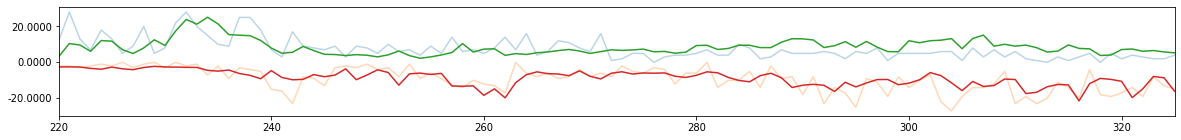

counts imp


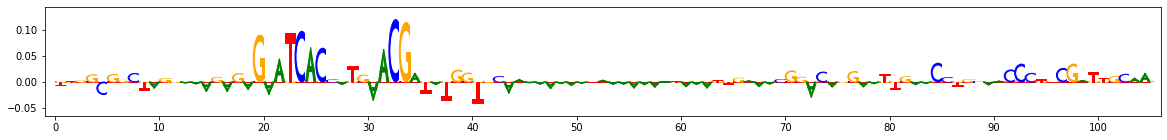

profile imp


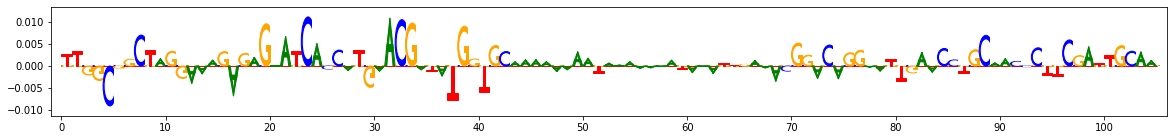

idx 50
Counts [1460. 1275.]
Predcounts [409.2245 564.9241]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


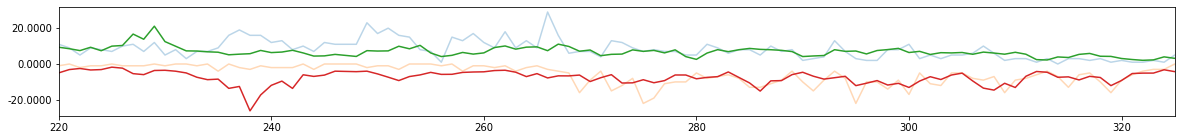

counts imp


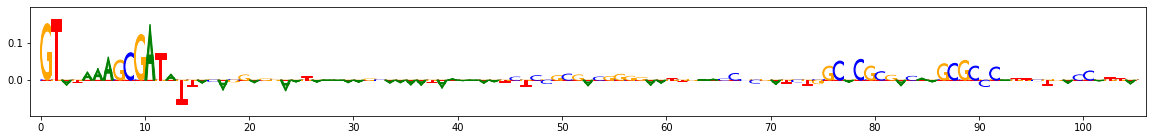

profile imp


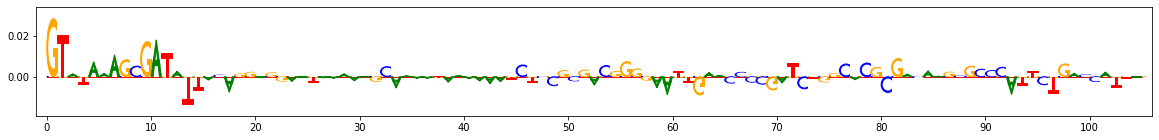

idx 25
Counts [ 976. 1284.]
Predcounts [1024.6293 1184.0463]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


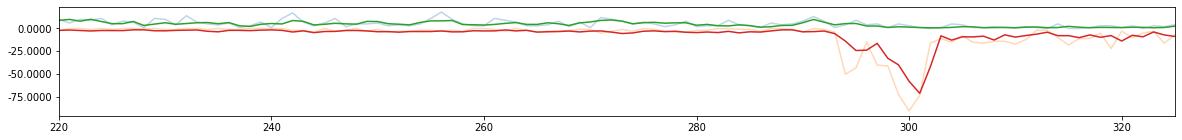

counts imp


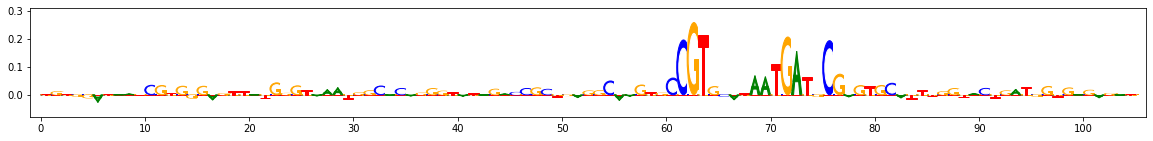

profile imp


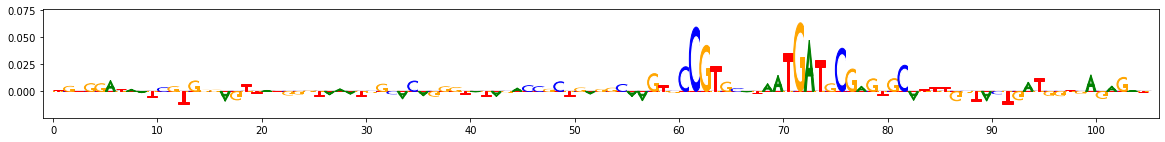

idx 0
Counts [1012. 1088.]
Predcounts [412.82416 446.46277]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


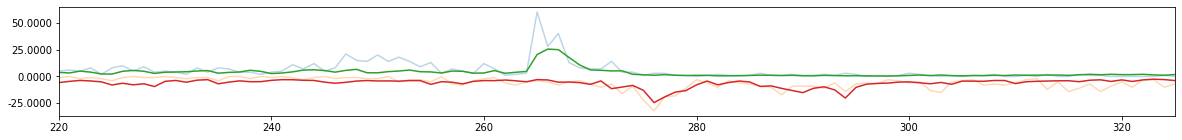

counts imp


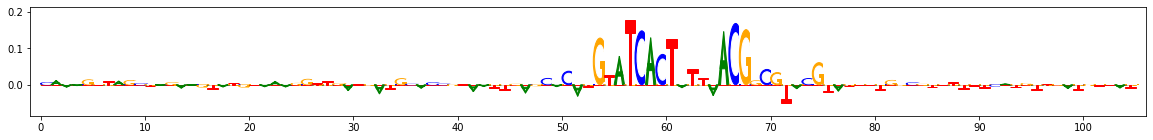

profile imp


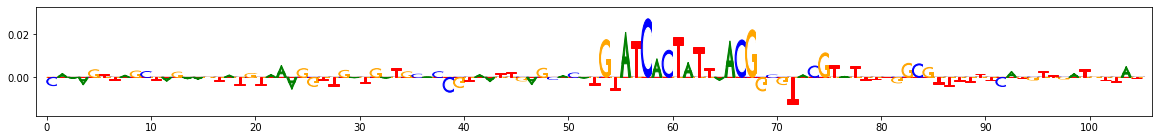

idx 56
Counts [1038.  932.]
Predcounts [687.0606  644.82654]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


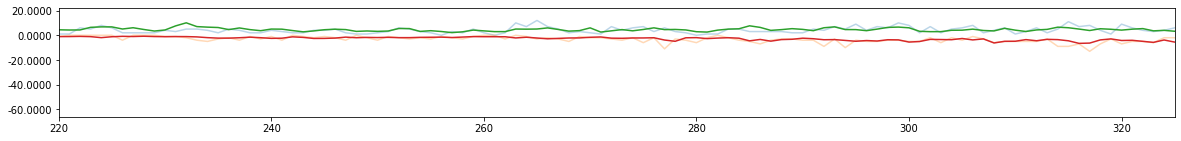

counts imp


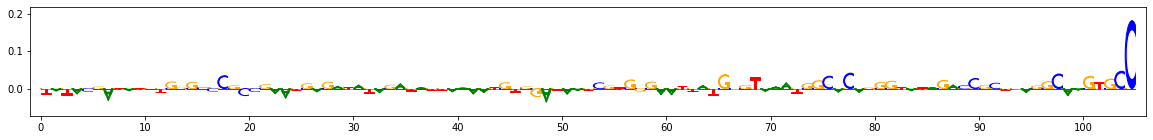

profile imp


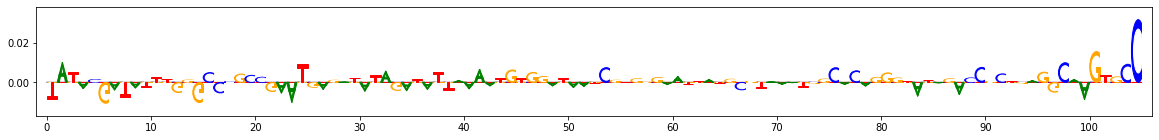

idx 44
Counts [787. 951.]
Predcounts [483.98584 550.1171 ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


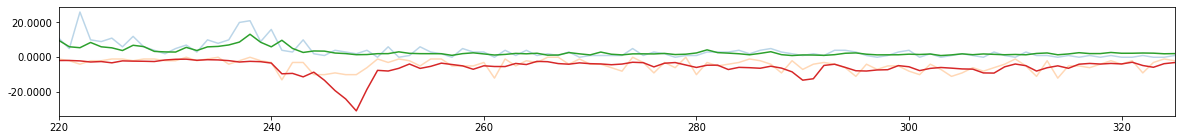

counts imp


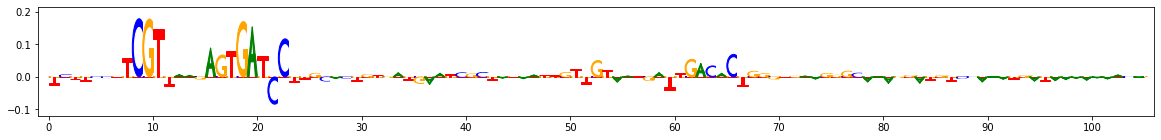

profile imp


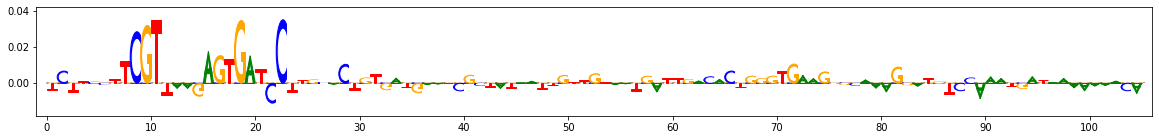

idx 34
Counts [879. 812.]
Predcounts [322.82935 316.03412]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


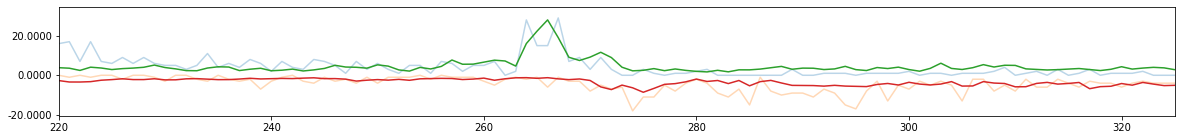

counts imp


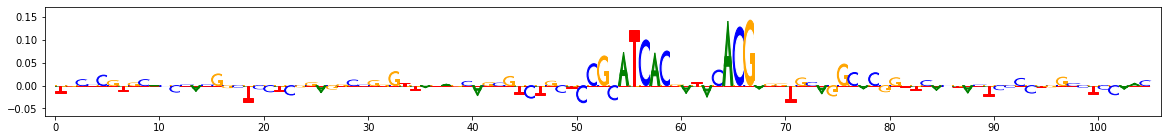

profile imp


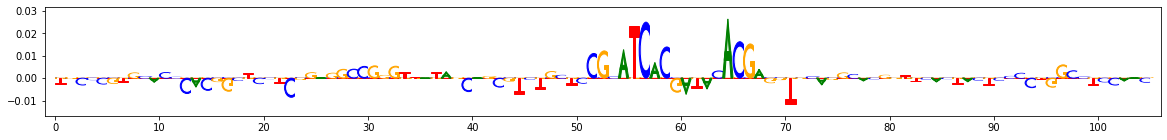

idx 4
Counts [831. 802.]
Predcounts [499.4573 437.9175]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


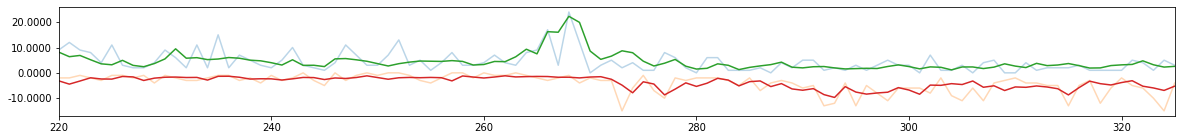

counts imp


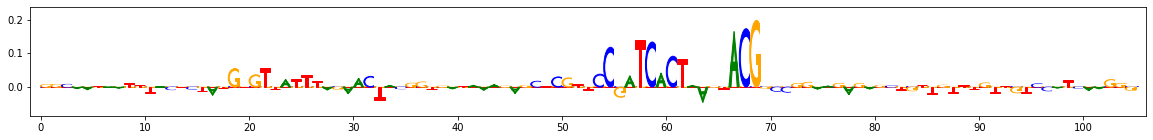

profile imp


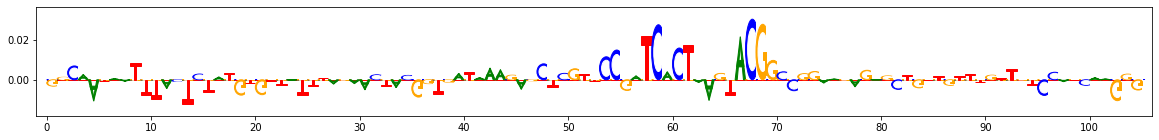

idx 2
Counts [774. 817.]
Predcounts [492.12784 501.0714 ]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


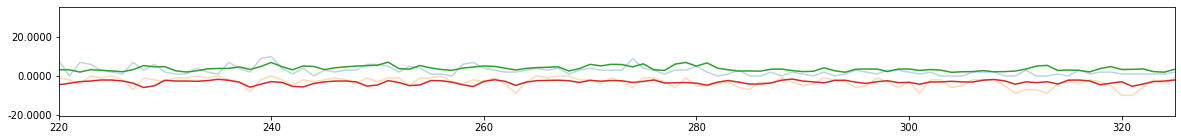

counts imp


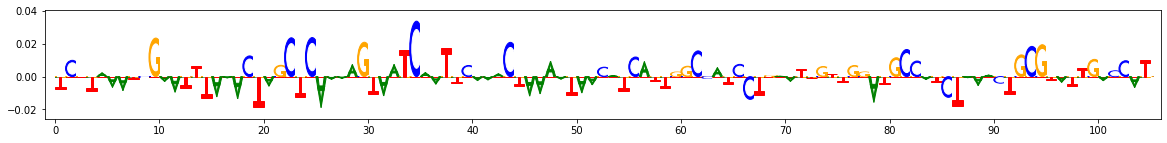

profile imp


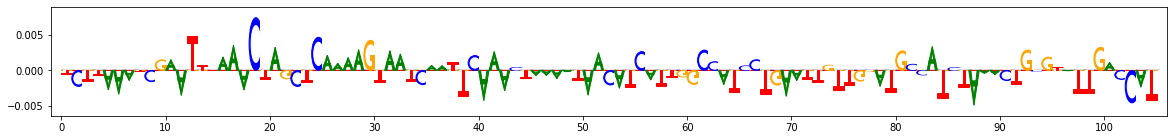

idx 26
Counts [761. 803.]
Predcounts [660.7153 723.7038]
oneovertemp 1.0
(225, 2)
Pred profile shape (225, 2)


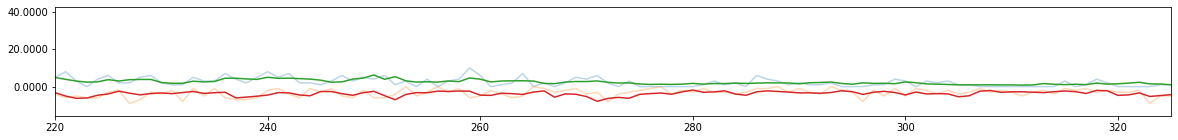

counts imp


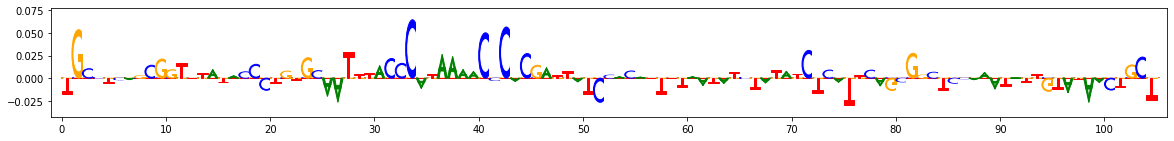

profile imp


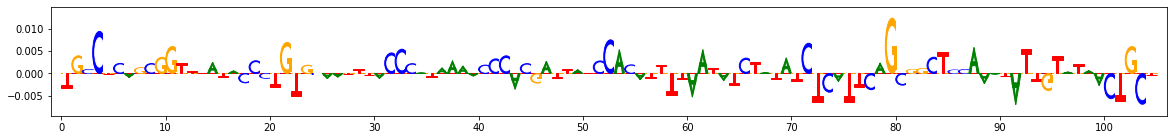

In [12]:
for idx in sorted_test_indices[:10]: 
    true_profile = o_test_labels_profile[idx] 
    print("idx",idx)
    print("Counts",np.sum(true_profile,axis=0))
    print("Predcounts",np.exp(o_test_preds_logcount[idx])-1)
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(o_test_labels_profile[idx].shape)
        print("Pred profile shape", o_test_preds_profile[idx].shape)
        pred_profile = (np.sum(o_test_labels_profile[idx], axis=0)[None,:] #total counts
                      *(np.exp(o_test_preds_profile[idx]*oneovertemp)/
                        np.sum(np.exp(o_test_preds_profile[idx]*oneovertemp),axis=0)[None,:]) )   
        plt.figure(figsize=(20,2))

        start_view = 220
        end_view = 325
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, smooth(true_profile[:,0]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, -smooth(true_profile[:,1]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
        plt.xlim(start_view,end_view)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[idx][start_view:end_view],
                            subticks_frequency=10)